# Assessing the performance of Gradient Boosting models for predicting the traveller’s mode choice patterns in an urban area, using travel household surveys

In [ ]:
# This cell will prompt you to connect this notebook with your google account.
from google.colab import drive                                                                        
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Docencia/art_JDPJ/en_proceso/ML_EOD2017/model/'

### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from numpy import interp
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
from tqdm import tqdm
import itertools
import seaborn as sns
from sklearn import *
import sklearn
import pickle

from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from scipy.stats import randint, uniform

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, jaccard_similarity_score, f1_score, accuracy_score, balanced_accuracy_score, roc_auc_score, recall_score, roc_curve, auc, roc_curve
from sklearn.utils import resample

from xgboost import XGBClassifier


#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 


print('Libraries read!')

Libraries read!


### Reading the final dataset

In [ ]:
raw_df_coord = pd.read_csv('raw_df_coord.csv').iloc[:,1:]
print('Shape of raw_df_coord:', raw_df_coord.shape)
raw_df_coord.head()

Shape of raw_df_coord: (43160, 42)


,travel_time,age,num_cars,num_motorbikes,num_bikes,reason_trip_home,reason_trip_study,reason_trip_work,parking_type_free,parking_type_paying,...,type_ownership_house_rent,stratum_lower,stratum_middle,lat_o,lon_o,lat_d,lon_d,lat_home,lon_home,main_mode
0,15.0,47.0,0,0,2,0,0,1,0,0,...,1,0,1,6.826402,-75.636002,6.826402,-75.636002,6.826402,-75.636002,walking_bike
1,10.0,47.0,0,0,2,1,0,0,0,0,...,1,0,1,6.826402,-75.636002,6.826402,-75.636002,6.826402,-75.636002,walking_bike
2,20.0,56.0,0,0,0,0,0,1,0,0,...,0,1,0,6.900502,-75.628899,6.963702,-75.638901,6.900502,-75.628899,walking_bike
3,30.0,56.0,0,0,0,1,0,0,0,0,...,0,1,0,6.963702,-75.638901,6.900502,-75.628899,6.900502,-75.628899,walking_bike
4,20.0,48.0,1,0,0,0,0,1,1,0,...,0,1,0,6.826402,-75.636002,6.826402,-75.636002,6.826402,-75.636002,car


In [ ]:
raw_df_coord.describe(include='all')

,travel_time,age,num_cars,num_motorbikes,num_bikes,reason_trip_home,reason_trip_study,reason_trip_work,parking_type_free,parking_type_paying,...,type_ownership_house_rent,stratum_lower,stratum_middle,lat_o,lon_o,lat_d,lon_d,lat_home,lon_home,main_mode
count,43160.000000,43160.000000,43160.000000,43160.000000,43160.000000,43160.000000,43160.000000,43160.000000,43160.000000,43160.000000,...,43160.000000,43160.000000,43160.000000,43160.000000,43160.000000,43160.000000,43160.000000,43160.000000,43160.000000,43160
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,walking_bike
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13195
mean,37.334893,38.966288,0.277085,0.351807,0.066613,0.471223,0.056186,0.327873,0.185542,0.025510,...,0.371571,0.531928,0.392609,16.998987,-75.568425,17.436055,-75.568403,9.494732,-75.567796,NaN
std,25.587222,15.080606,0.580293,0.605247,0.320217,0.499177,0.230284,0.469444,0.388741,0.157669,...,0.483230,0.498985,0.488337,259.091759,0.056897,264.328131,0.056946,142.873060,0.058900,NaN
min,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.946810,-75.794502,5.946810,-75.794502,6.108410,-75.690102,NaN
25%,15.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,6.199950,-75.595703,6.199950,-75.595703,6.192980,-75.599098,NaN
50%,30.000000,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,6.251980,-75.573700,6.251980,-75.573700,6.264820,-75.574402,NaN
75%,60.000000,50.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,6.299080,-75.557297,6.297620,-75.557602,6.313250,-75.552002,NaN


In [ ]:
raw_df_coord['main_mode'].value_counts()

walking_bike    13195
bus              8753
sitva            8291
motorbike        7087
car              5000
taxi              834
Name: main_mode, dtype: int64

In [ ]:
# Replacing main modes
raw_df_coord['main_mode'] = raw_df_coord['main_mode'].replace(['walking_bike', 'bus', 'sitva', 'motorbike', 'car', 'taxi'],
                                                  ['walking_bike', 'public', 'public', 'private', 'private', 'public'])

In [ ]:
# Splitting data in X and Y
y = raw_df_coord['main_mode']
X = raw_df_coord.drop('main_mode',axis = 1)

In [ ]:
# Splitting data in training and test data
seed = 42
test_size = 0.25
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=seed, stratify=y)
print('Shape of X_train: ', X_train.shape, ' and y_train: ', y_train.shape)
print('Shape of X_test: ', X_test.shape, ' and y_test: ', y_test.shape)

Shape of X_train:  (32370, 41)  and y_train:  (32370,)
Shape of X_test:  (10790, 41)  and y_test:  (10790,)


In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # apply same transformation to test data

## Verifying the Gradient Boosting Model

In [ ]:
XGB_params = XGBClassifier(objective='multi:softprob')
XGB = XGB_params.fit(X_train,y_train)
XGB



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

Now we can predict using our test set:

In [ ]:
yhat = XGB.predict(X_test)
yhat[0:20]

array(['public', 'public', 'private', 'public', 'public', 'public',
       'public', 'walking_bike', 'public', 'private', 'public',
       'walking_bike', 'private', 'private', 'public', 'walking_bike',
       'private', 'walking_bike', 'public', 'public'], dtype=object)

predict_proba returns estimates for all classes, ordered by the label of classes. So, the first column is the probability of class 0, P(Y=0|X), the second column is probability of class 1, P(Y=1|X), and the third column is probability of class 2, P(Y=2|X):

In [ ]:
yhat_prob = XGB.predict_proba(X_test)
yhat_prob

array([[9.88e-03, 9.66e-01, 2.44e-02],
       [2.35e-01, 7.18e-01, 4.69e-02],
       [9.99e-01, 4.23e-04, 8.48e-05],
       ...,
       [1.24e-02, 1.48e-01, 8.39e-01],
       [5.54e-02, 9.14e-01, 3.06e-02],
       [8.63e-03, 4.08e-01, 5.83e-01]], dtype=float32)

### 4.1. Balanced_accuracy

In [ ]:
print('balanced_accuracy_train: ', round(balanced_accuracy_score(y_train, XGB.predict(X_train)),2))
print('balanced_accuracy_test: ', round(balanced_accuracy_score(y_test, XGB.predict(X_test)),2))

balanced_accuracy_train:  0.94
balanced_accuracy_test:  0.88


### 4.2. F1-score

For information about this metric, see https://en.wikipedia.org/wiki/F1_score#Extension_to_multi-class_classification

In [ ]:
print('f1_score_train: ', f1_score(y_train, XGB.predict(X_train), average=None))
print('f1_score_test: ', f1_score(y_test, yhat, average=None))

f1_score_train:  [0.95 0.94 0.93]
f1_score_test:  [0.9  0.88 0.88]


In [ ]:
f1_score(y_test, yhat, average='macro')


print('f1_score_train: ', round(f1_score(y_train, XGB.predict(X_train), average='macro'),2))
print('f1_score_test: ', round(f1_score(y_test, yhat, average='macro'),2))

f1_score_train:  0.94
f1_score_test:  0.88


### 4.3. Confusion matrix
Another way of looking at accuracy of classifier is to look at __confusion matrix__.

In [ ]:
# Defining plot_confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.1 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
cnf_matrix = confusion_matrix(y_test, yhat)
cnf_matrix

array([[2551,  354,  117],
       [  85, 4065,  319],
       [  42,  350, 2907]])

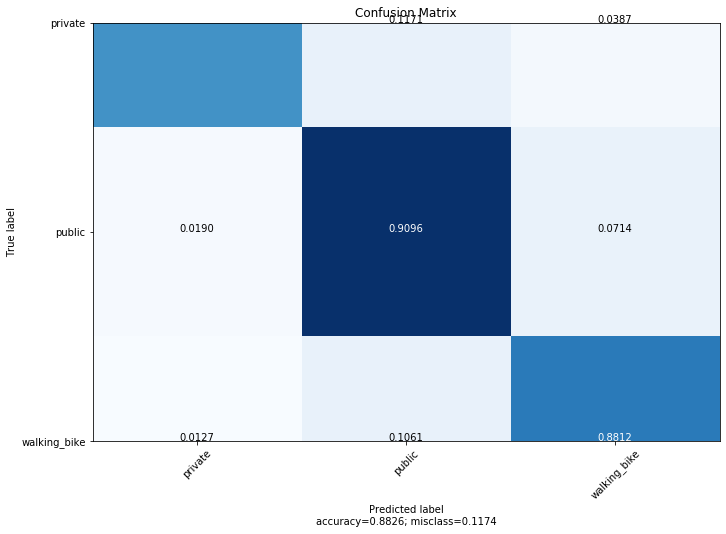

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, 
                      normalize    = True,
                      target_names = ['private', 'public', 'walking_bike'],
                      title        = "Confusion Matrix")



### 4.5. Plotting Learning Curve

In [ ]:
# learning curve f1_macro
def plot_learning_curve(estimator, X, y, cv=None, ylim=None):
    
    plt.figure()
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.ylabel('f1_macro', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14) 
    
    train_sizes, train_scores, validation_scores = model_selection.learning_curve(
        estimator, X, y, cv=5, train_sizes=np.linspace(.1, 1.0, 50), scoring = 'f1_macro')
    
    train_scores_mean = np.mean(train_scores, axis = 1)
    validation_scores_mean = np.mean(validation_scores, axis = 1)
    
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)


    plt.plot(train_sizes, train_scores_mean, color="r", label = 'Training data')
    plt.plot(train_sizes, validation_scores_mean, color="g", label = 'Validation data')
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    

    plt.legend(loc="best")
    #plt.yticks(np.arange(0.7, 0.9, 0.01))
    plt.ylim()
    
    return plt





<module 'matplotlib.pyplot' from '/home/daniel/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

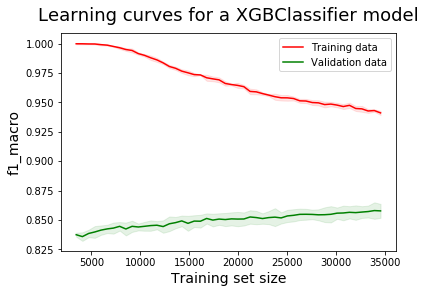

In [ ]:
# learning curve f1_macro
cv = model_selection.ShuffleSplit(n_splits = 50, test_size = 0.25, random_state = 42)
estimator = XGB_params
plot_learning_curve(estimator, X, y, ylim=(), cv=cv)



In [ ]:
# learning curve balanced_accuracy
def plot_learning_curve_bal_acc(estimator, X, y, cv=None, ylim=None):
    
    plt.figure()
    title = 'Learning curves for a ' + str(estimator).split('(')[0] + ' model'
    plt.title(title, fontsize = 18, y = 1.03)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.ylabel('Balanced Accuracy', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14) 
    
    train_sizes, train_scores, validation_scores = model_selection.learning_curve(
        estimator, X, y, cv=5, train_sizes=np.linspace(.1, 1.0, 50), scoring = 'balanced_accuracy')
    
    train_scores_mean = np.mean(train_scores, axis = 1)
    validation_scores_mean = np.mean(validation_scores, axis = 1)
    
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)


    plt.plot(train_sizes, train_scores_mean, color="r", label = 'Training data')
    plt.plot(train_sizes, validation_scores_mean, color="g", label = 'Validation data')
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    

    plt.legend(loc="best")
    #plt.yticks(np.arange(0.7, 0.9, 0.01))
    plt.ylim()
    
    return plt




<module 'matplotlib.pyplot' from '/home/daniel/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

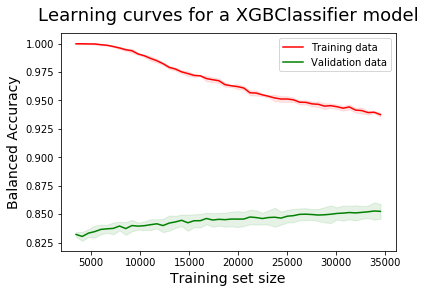

In [ ]:
# learning curve balanced_accuracy
cv = model_selection.ShuffleSplit(n_splits = 50, test_size = 0.2, random_state = 42)
estimator = XGB_params
plot_learning_curve_bal_acc(estimator, X, y, ylim=(), cv=cv)

## Hyperparameter tuning using the grid search method

In [ ]:
# Analysing for n_estimators, learning_rate and max_depth
n_estimators=[]
max_depth=[]
learning_rate = []
bal_acc = []
for i in tqdm(range(1,101)):
    for j in range(2,10):
        for k in [0.005, 0.01, 0.05, 0.1, 0.5, 1]:
            XGB_params = XGBClassifier(objective='multi:softprob', n_estimators=i, max_depth=j, learning_rate=k)
            XGB = XGB_params.fit(X_train,y_train)
            ypred_train = XGB.predict(X_train)
            ypred_test = XGB.predict(X_test)
    
            bal_acc.append(round(balanced_accuracy_score(y_test, ypred_test), 2))
            n_estimators.append(i)
            max_depth.append(j)
            learning_rate.append(k)

100%|██████████| 100/100 [6:19:06<00:00, 426.21s/it] 


In [ ]:
tuning = pd.DataFrame(list(zip(n_estimators, max_depth, learning_rate, bal_acc)), columns=['n_estimators', 'max_depth', 'learning_rate', 'bal_acc'])
tuning.sort_values(by=['bal_acc'], inplace=True, ascending=False)

tuning.to_csv('tuning_GB.csv')
tuning.head(10)

,n_estimators,max_depth,learning_rate,bal_acc
4799,100,9,1.0,0.89
4457,93,8,1.0,0.89
3442,72,7,0.5,0.89
3443,72,7,1.0,0.89
3448,72,8,0.5,0.89
2303,48,9,1.0,0.89
3449,72,8,1.0,0.89
2302,48,9,0.5,0.89
2722,57,7,0.5,0.89
3454,72,9,0.5,0.89


In [ ]:
tuning = pd.read_csv('tuning_GB.csv').iloc[:,1:]
print('Shape of tuning:', tuning.shape)
tuning.head()

Shape of tuning: (4800, 4)


,n_estimators,max_depth,learning_rate,bal_acc
0,100,9,1.0,0.89
1,93,8,1.0,0.89
2,72,7,0.5,0.89
3,72,7,1.0,0.89
4,72,8,0.5,0.89


In [ ]:
# Grid search for learning_rate for comparing the performance of the model in the training and the test data

learning_rate=[]
bal_acc_train = []
bal_acc_test = []


for i in tqdm(np.arange(0.01,1.01,0.01)):

    model = XGBClassifier(objective='multi:softprob', n_estimators=31, max_depth=9, learning_rate=i)
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="balanced_accuracy")
  
    model_result = model.fit(X_train,y_train)
    ypred_train = model_result.predict(X_train)
    ypred_test = model_result.predict(X_test)
    
    balanced_accuracy_train = balanced_accuracy_score(y_train, ypred_train)
    balanced_accuracy_test = balanced_accuracy_score(y_test, ypred_test)

    bal_acc_train.append(balanced_accuracy_train)
    bal_acc_test.append(balanced_accuracy_test)
    learning_rate.append(i)

tuning_learning_rate_train_test_GB = pd.DataFrame(list(zip(learning_rate, bal_acc_train, bal_acc_test)), columns=['learning_rate', 'bal_acc_train', 'bal_acc_test'])

tuning_learning_rate_train_test_GB.to_csv('tuning_learning_rate_train_test_GB.csv')
tuning_learning_rate_train_test_GB.head(10)


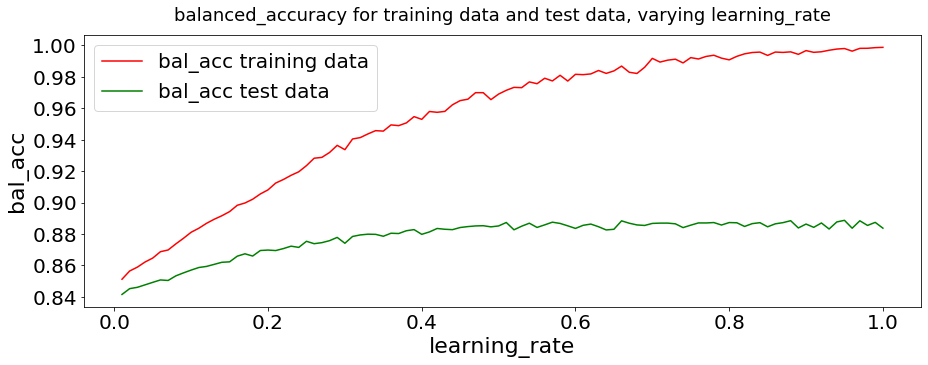

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.title('balanced_accuracy for training data and test data, varying learning_rate', fontsize = 18, y = 1.03)
plt.ylabel('bal_acc', fontsize = 22)
plt.xlabel('learning_rate', fontsize = 22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
plt.plot(learning_rate, bal_acc_train, color="r", label = 'bal_acc training data')
plt.plot(learning_rate, bal_acc_test, color="g", label = 'bal_acc test data')
plt.legend(loc="best",  fontsize=20)

plt.show()

100%|██████████| 8/8 [04:04<00:00, 38.25s/it]


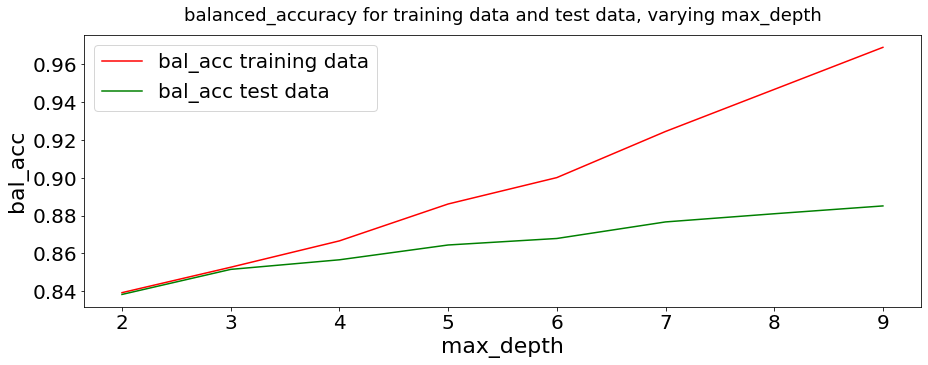

In [ ]:
# Grid search for max_depth for comparing the performance of the model in the training and the test data

max_depth=[]
bal_acc_train = []
bal_acc_test = []


for i in tqdm(range(2,10)):

    model = XGBClassifier(objective='multi:softprob', n_estimators=31, max_depth=i, learning_rate=0.5)
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="balanced_accuracy")
  
    model_result = model.fit(X_train,y_train)
    ypred_train = model_result.predict(X_train)
    ypred_test = model_result.predict(X_test)
    
    balanced_accuracy_train = balanced_accuracy_score(y_train, ypred_train)
    balanced_accuracy_test = balanced_accuracy_score(y_test, ypred_test)

    bal_acc_train.append(balanced_accuracy_train)
    bal_acc_test.append(balanced_accuracy_test)
    max_depth.append(i)

tuning_max_depth_train_test_GB = pd.DataFrame(list(zip(max_depth, bal_acc_train, bal_acc_test)), columns=['max_depth', 'bal_acc_train', 'bal_acc_test'])

tuning_max_depth_train_test_GB.to_csv('tuning_max_depth_train_test_GB.csv')
tuning_max_depth_train_test_GB.head(10)

fig = plt.figure(figsize=(15,5))

plt.title('balanced_accuracy for training data and test data, varying max_depth', fontsize = 18, y = 1.03)
plt.ylabel('bal_acc', fontsize = 22)
plt.xlabel('max_depth', fontsize = 22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
plt.plot(max_depth, bal_acc_train, color="r", label = 'bal_acc training data')
plt.plot(max_depth, bal_acc_test, color="g", label = 'bal_acc test data')
plt.legend(loc="best",  fontsize=20)

plt.show()

100%|██████████| 100/100 [2:11:00<00:00, 148.74s/it]


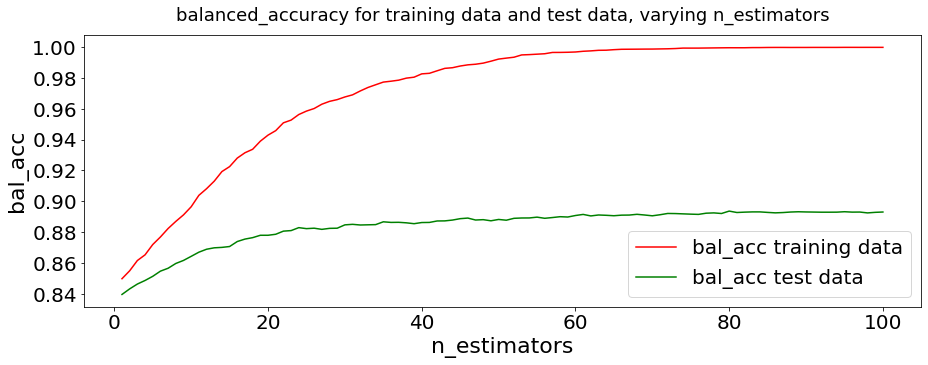

In [ ]:
# Grid search for n_estimators for comparing the performance of the model in the training and the test data

n_estimators=[]
bal_acc_train = []
bal_acc_test = []


for i in tqdm(range(1,101)):

    model = XGBClassifier(objective='multi:softprob', n_estimators=i, max_depth=9, learning_rate=0.5)
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="balanced_accuracy")
  
    model_result = model.fit(X_train,y_train)
    ypred_train = model_result.predict(X_train)
    ypred_test = model_result.predict(X_test)
    
    balanced_accuracy_train = balanced_accuracy_score(y_train, ypred_train)
    balanced_accuracy_test = balanced_accuracy_score(y_test, ypred_test)

    bal_acc_train.append(balanced_accuracy_train)
    bal_acc_test.append(balanced_accuracy_test)
    n_estimators.append(i)

tuning_n_estimators_train_test_GB = pd.DataFrame(list(zip(n_estimators, bal_acc_train, bal_acc_test)), columns=['n_estimators', 'bal_acc_train', 'bal_acc_test'])

tuning_n_estimators_train_test_GB.to_csv('tuning_n_estimators_train_test_GB.csv')
tuning_n_estimators_train_test_GB.head(10)

fig = plt.figure(figsize=(15,5))

plt.title('balanced_accuracy for training data and test data, varying n_estimators', fontsize = 18, y = 1.03)
plt.ylabel('bal_acc', fontsize = 22)
plt.xlabel('n_estimators', fontsize = 22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
    
plt.plot(n_estimators, bal_acc_train, color="r", label = 'bal_acc training data')
plt.plot(n_estimators, bal_acc_test, color="g", label = 'bal_acc test data')
plt.legend(loc="best",  fontsize=20)

plt.show()


# Watching the selected XGB Model

In [ ]:
XGB_params = XGBClassifier(objective='multi:softprob',n_estimators=11, max_depth=10, learning_rate=0.17)
XGB = XGB_params.fit(X_train,y_train)

ypred_train = XGB.predict(X_train)
ypred_test = XGB.predict(X_test)


print('balanced_accuracy_train is: ', round(balanced_accuracy_score(y_train, ypred_train), 3))
print('balanced_accuracy_test is: ', round(balanced_accuracy_score(y_test, ypred_test), 3))

print('f1_score_train is: ', f1_score(y_train, ypred_train, average=None))
print('f1_score_test is: ', f1_score(y_test, ypred_test, average=None))

print('f1_score_train_macro is: ', round(f1_score(y_train, ypred_train, average='macro'), 3))
print('f1_score_test_macro is: ', round(f1_score(y_test, ypred_test, average='macro'), 3))


balanced_accuracy_train is:  0.885
balanced_accuracy_test is:  0.856
f1_score_train is:  [0.911 0.89  0.875]
f1_score_test is:  [0.885 0.863 0.843]
f1_score_train_macro is:  0.892
f1_score_test_macro is:  0.864


In [ ]:
cnf_matrix = confusion_matrix(y_test, ypred_test)
cnf_matrix

array([[2471,  394,  157],
       [  59, 4071,  339],
       [  34,  498, 2767]])

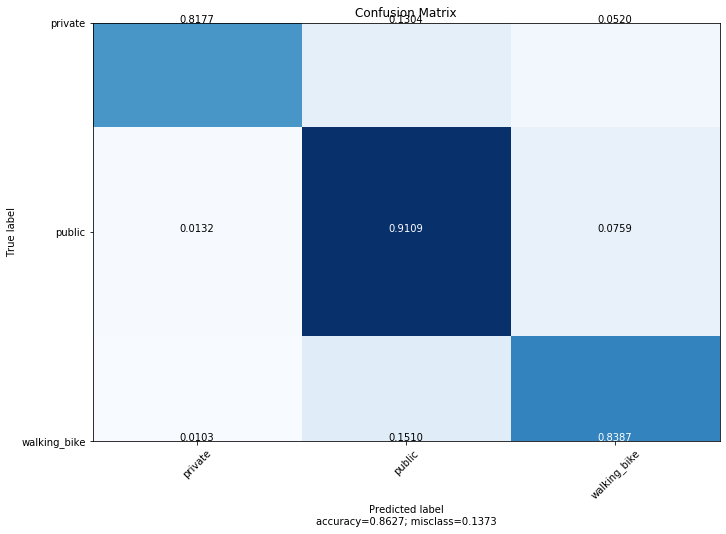

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, ypred_test)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, 
                      normalize    = True,
                      target_names = ['private', 'public', 'walking_bike'],
                      title        = "Confusion Matrix")



<module 'matplotlib.pyplot' from '/home/daniel/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

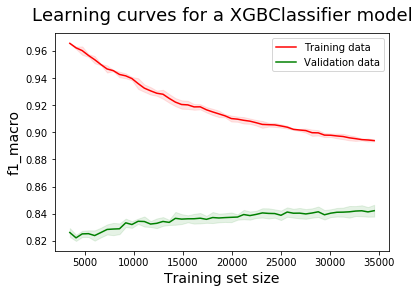

In [ ]:
# learning curve f1_macro
cv = model_selection.ShuffleSplit(n_splits = 50, test_size = 0.2, random_state = 42)
estimator = XGB_params
plot_learning_curve(estimator, X, y, ylim=(), cv=cv)

<module 'matplotlib.pyplot' from '/home/daniel/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

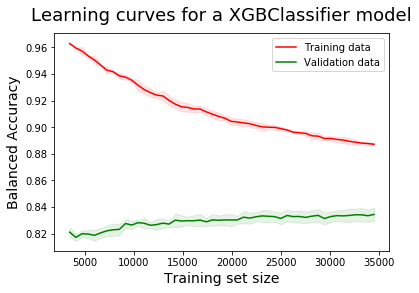

In [ ]:
# learning curve balanced accuracy
cv = model_selection.ShuffleSplit(n_splits = 50, test_size = 0.2, random_state = 42)
estimator = XGB_params
plot_learning_curve_bal_acc(estimator, X, y, ylim=(), cv=cv)

Feature: 0, Score: 0.09925
Feature: 1, Score: 0.00322
Feature: 2, Score: 0.01126
Feature: 3, Score: 0.01284
Feature: 4, Score: 0.00465
Feature: 5, Score: 0.00073
Feature: 6, Score: 0.00155
Feature: 7, Score: 0.00403
Feature: 8, Score: 0.62404
Feature: 9, Score: 0.13638
Feature: 10, Score: 0.00343
Feature: 11, Score: 0.00340
Feature: 12, Score: 0.00188
Feature: 13, Score: 0.01184
Feature: 14, Score: 0.00442
Feature: 15, Score: 0.00585
Feature: 16, Score: 0.00587
Feature: 17, Score: 0.00248
Feature: 18, Score: 0.00200
Feature: 19, Score: 0.00943
Feature: 20, Score: 0.00191
Feature: 21, Score: 0.00315
Feature: 22, Score: 0.00223
Feature: 23, Score: 0.00213
Feature: 24, Score: 0.00432
Feature: 25, Score: 0.00120
Feature: 26, Score: 0.00169
Feature: 27, Score: 0.00163
Feature: 28, Score: 0.00270
Feature: 29, Score: 0.00182
Feature: 30, Score: 0.00250
Feature: 31, Score: 0.00219
Feature: 32, Score: 0.00210
Feature: 33, Score: 0.00214
Feature: 34, Score: 0.00238
Feature: 35, Score: 0.00275
Fe

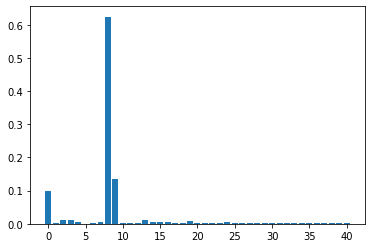

Index(['travel_time', 'age', 'num_cars', 'num_motorbikes', 'num_bikes',
       'reason_trip_home', 'reason_trip_study', 'reason_trip_work',
       'parking_type_free', 'parking_type_paying', 'gender_male',
       'schooling_lower', 'schooling_middle', 'occupation_employee',
       'occupation_housewife', 'occupation_student',
       'work_dedication_full_time', 'work_dedication_partial_time',
       'laboral_sector_industry', 'laboral_sector_services',
       'work_level_assistant', 'work_level_manager', 'work_level_operative',
       'workplace_home', 'workplace_office', 'disability_yes',
       'household_income_smlv_1_2', 'household_income_smlv_2_3',
       'household_income_smlv_3_mas', 'type_home_apartment', 'type_home_house',
       'type_ownership_house_own', 'type_ownership_house_rent',
       'stratum_lower', 'stratum_middle', 'lat_o', 'lon_o', 'lat_d', 'lon_d',
       'lat_home', 'lon_home'],
      dtype='object')


In [ ]:
# Importance of each feature
importance = XGB_params.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()
print(X.columns)

### Saving the model

In [ ]:
XGB_model_final = 'XGB_model_final.sav'
pickle.dump(XGB, open(XGB_model_final, 'wb')) #Just save the model once